# Table of Contents

1. [Installing dependencies](#Installing-dependencies)
2. [Package imports](#Package-imports)
3. [Read and preprocess news data](#news-data)
4. [Read and preprocess S&P500 data](#s&p-500-data)
5. [GenAI sentiment data](#GenAI-sentiment-data)
6. [AutoML](#AutoML-to-refine-algorithms)
7. [MLFlow](#mlflow)  
    a. [Model Serving](#model-serving)  
    b. [Model Monitoring](#model-monitoring)


## Installing dependencies

In [ ]:
%pip install --upgrade pip
%pip install --quiet numpy==1.26.4 pandas scipy==1.11.4 scikit-learn==1.4.2 "pyarrow>=14,<20" 'pycaret[analysis,models]==3.3.2' mlflow shap evidently

## Package imports

In [3]:
import pandas as pd
pd.set_option('display.max_columns',None)

import numpy as np

import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_recall_fscore_support,
    classification_report,
)

from pycaret.classification import (
    setup as clf_setup,
    compare_models as clf_compare,
    finalize_model as clf_finalize,
    predict_model as clf_predict,
)

import shap
import matplotlib.pyplot as plt

import json
import os
import tempfile

import warnings
warnings.filterwarnings("ignore")

In [6]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))

DATA_DIR = os.path.join(PROJECT_ROOT, "data")

## News data

In [7]:
cnbc = pd.read_csv(os.path.join(DATA_DIR, "cnbc_headlines.csv"))
guardian = pd.read_csv(os.path.join(DATA_DIR, "guardian_headlines.csv"))
reuters = pd.read_csv(os.path.join(DATA_DIR, "reuters_headlines.csv"))

In [8]:
### Prepare each source dataframe to merge later ###
def prepare_source(df, source_name, has_description=True):
    """
    Standardize column names to be lower case, add the source column, and replace description = headline if there is no description. 
    """

    df = df.copy()

    # Rename columns
    rename_map = {
        "Headlines": "headline",
        "Time": "time",
        "Description": "description"
    }
    df = df.rename(columns=rename_map)

    # Replace description = headline if there is no description
    if not has_description:
        df['description'] = df['headline']

    df['source'] = source_name

    # Sort order of the columns
    return df[["time", "headline", "description", "source"]]

In [9]:
cnbc_std = prepare_source(cnbc, "cnbc", has_description=True)
guardian_std = prepare_source(guardian, "guardian", has_description=False)
reuters_std = prepare_source(reuters, "reuters", has_description=True)

# Append (stack) all rows on top of each other
news_all = pd.concat([cnbc_std, guardian_std, reuters_std], ignore_index=True)

In [10]:
### Basic text cleaning ###

# Ensure headline/description are strings and strip whitespace
news_all["headline"] = news_all["headline"].astype(str).str.strip()
news_all["description"] = news_all["description"].astype(str).str.strip()

# Sometimes there are weird line breaks / multiple spaces in Guardian
news_all["headline"] = news_all["headline"].str.replace(r"\s+", " ", regex=True)
news_all["description"] = news_all["description"].str.replace(r"\s+", " ", regex=True)

# Drop rows where headline is empty after stripping
news_all = news_all[news_all["headline"].str.len() > 0]

# --- Time parsing & cleaning ---

# Convert time column to datetime, coerce invalid formats to NaT (missing)
news_all["time"] = pd.to_datetime(news_all["time"], errors="coerce")

# Drop rows where time could not be parsed
news_all = news_all.dropna(subset=["time"])

# Create a pure date column (will be super useful later when we aggregate per day)
news_all["date"] = news_all["time"].dt.date

# --- Handle duplicates ---

# Drop exact duplicate rows (same time, headline, description, source)
news_all = news_all.drop_duplicates(subset=["time", "headline", "description", "source"])

In [11]:
news_all["text"] = (
    news_all["headline"].fillna("") 
    + ". " + 
    news_all["description"].fillna("")
)

## S&P 500 data

In [12]:
sp500 = pd.read_csv(os.path.join(DATA_DIR, "sp500.csv"))

In [13]:
def label_return_bucket(r):
    if r > 0.5:
        return "up"
    elif r > 0:
        return "slightly_up"
    elif r >= -0.5:
        return "slightly_down"
    else:
        return "down"

model_df = sp500.copy()
model_df["return_bucket"] = model_df["return_t_plus_1"].apply(label_return_bucket)

# Quick check: counts of each bucket
print(model_df["return_bucket"].value_counts())
print("\nShares:\n", model_df["return_bucket"].value_counts(normalize=True))

return_bucket
up               1858
slightly_up      1648
down             1582
slightly_down    1434
Name: count, dtype: int64

Shares:
 return_bucket
up               0.284882
slightly_up      0.252683
down             0.242564
slightly_down    0.219871
Name: proportion, dtype: float64


### GenAI sentiment data
#### Sentiments created using Gemma 3

In [14]:
# Import daily sentiment
daily_sentiment = pd.read_csv(os.path.join(DATA_DIR, "daily_sentiment.csv"))

In [15]:
daily_sentiment["sentiment_score"] = (daily_sentiment["Positive"] - daily_sentiment["Negative"]) / (daily_sentiment["Total"])

In [16]:
daily_sentiment["net_sentiment"] = (daily_sentiment["Positive"] - daily_sentiment["Negative"]) / (daily_sentiment["Positive"] + daily_sentiment["Negative"])

In [17]:
daily_sentiment["date"] = pd.to_datetime(daily_sentiment["date"])
model_df["date"] = pd.to_datetime(model_df["date"])

In [18]:
model_df_merged = model_df.merge(
    daily_sentiment[["date", "sentiment_score", "net_sentiment"]],
    on="date",
    how="left"
)

#### Sentiment by news categories

In [19]:
all_news = pd.read_csv(os.path.join(DATA_DIR, "all_news_final.csv"))

In [20]:
all_news.shape

(53272, 10)

In [21]:
all_news = all_news[all_news['confidence']>0.7].reset_index(drop=True)

In [22]:
all_news.shape

(48780, 10)

In [23]:
# make sure date is datetime (optional)
all_news["date"] = pd.to_datetime(all_news["date"])

# --- counts per (date, category, sentiment) ---
cat_counts = (
    all_news
    .groupby(["date", "category", "sentiment"])
    .size()
    .unstack(fill_value=0)        # columns: Positive / Negative / Neutral (if present)
    .reset_index()
)

# ensure columns exist even if some sentiment never appears
for col in ["Positive", "Negative", "Neutral"]:
    if col not in cat_counts.columns:
        cat_counts[col] = 0

# total news per date & category
cat_counts["total_cat_news"] = cat_counts[["Positive", "Negative", "Neutral"]].sum(axis=1)

# avoid division by zero
cat_counts["total_cat_news"] = cat_counts["total_cat_news"].replace(0, pd.NA)

# category-level sentiment index
cat_counts["cat_sentiment"] = (
    (cat_counts["Positive"] - cat_counts["Negative"]) / cat_counts["total_cat_news"]
)

# wide format: one column per category
cat_sent_wide = (
    cat_counts
    .pivot(index="date", columns="category", values="cat_sentiment")
    .add_prefix("sentiment_")      # e.g. sentiment_Healthcare, sentiment_Technology
    .reset_index()
)

cat_sent_wide.head()

category,date,sentiment_Airlines,sentiment_Automobile,sentiment_Corporate,sentiment_Economy,sentiment_Energy,sentiment_Geo-Political,sentiment_Healthcare,sentiment_Technology,sentiment_US Politics
0,2017-12-17,NaN,NaN,-0.333333,NaN,0.333333,-1.0,NaN,1.0,-0.6
1,2017-12-18,0.0,-1.0,-0.333333,-1.0,-0.333333,-1.0,NaN,-1.0,-0.6
2,2017-12-19,-1.0,-1.0,-0.5,-1.0,1.0,NaN,NaN,NaN,-0.5
3,2017-12-20,NaN,NaN,-1.0,NaN,1.0,-1.0,1.0,NaN,-0.5
4,2017-12-21,1.0,-1.0,0.0,NaN,NaN,0.0,-1.0,1.0,-0.75


In [24]:
# counts per (date, sentiment)
daily_sent = (
    all_news
    .groupby(["date", "sentiment"])
    .size()
    .unstack(fill_value=0)        # columns: Positive / Negative / Neutral
)

for col in ["Positive", "Negative", "Neutral"]:
    if col not in daily_sent.columns:
        daily_sent[col] = 0

daily_sent["total_news"] = daily_sent[["Positive", "Negative", "Neutral"]].sum(axis=1)
daily_sent["total_news"] = daily_sent["total_news"].replace(0, pd.NA)

daily_sent["overall_sentiment"] = (
    (daily_sent["Positive"] - daily_sent["Negative"]) / daily_sent["total_news"]
)

daily_sent = daily_sent[["overall_sentiment"]].reset_index()

In [25]:
final_daily = cat_sent_wide.merge(daily_sent, on="date", how="left")

In [26]:
final_daily_filled = final_daily.copy()

# All sentiment columns (category-level) + overall
sent_cols = [c for c in final_daily_filled.columns if c.startswith("sentiment_")]
sent_cols.append("overall_sentiment")

for col in sent_cols:
    if col in final_daily_filled.columns:
        final_daily_filled[col] = final_daily_filled[col].fillna(0.0)

In [27]:
model_df_merged = model_df_merged.merge(
    final_daily_filled,
    on="date",
    how="left"
)

# In case some dates exist in returns but not in news at all:
sent_cols_all = [c for c in model_df_merged.columns if c.startswith("sentiment_")] + ["overall_sentiment"]
for col in sent_cols_all:
    if col in model_df_merged.columns:
        model_df_merged[col] = model_df_merged[col].fillna(0.0)

## AutoML to refine algorithms

In [28]:
model_final = model_df_merged[model_df_merged['net_sentiment'].notna()].reset_index(drop=True)

In [29]:
model_final = model_final.drop(columns=['sentiment_score','net_sentiment'])

In [30]:
# Copy the dataframe
df = model_final.copy()

In [31]:
target_col = "return_bucket"

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=df[target_col],
)

train_df = train_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

print(train_df[target_col].value_counts(normalize=True))
print(test_df[target_col].value_counts(normalize=True))

return_bucket
up               0.298561
slightly_up      0.267986
down             0.224820
slightly_down    0.208633
Name: proportion, dtype: float64
return_bucket
up               0.302158
slightly_up      0.266187
down             0.223022
slightly_down    0.208633
Name: proportion, dtype: float64


In [32]:
feature_cols_sector = [
    "sentiment_Airlines",
    "sentiment_Automobile",
    "sentiment_Corporate",
    "sentiment_Economy",
    "sentiment_Energy",
    "sentiment_Geo-Political", 
    "sentiment_Healthcare",
    "sentiment_Technology",
    "sentiment_US Politics",
    "overall_sentiment",
]

In [38]:
# Define feature sets
feature_sets = {
    "Sectoral sentiment": feature_cols_sector
}

# Helper function to detect prediction column from pycaret's predict_model()
def get_prediction_column(pred_df: pd.DataFrame, feature_cols):
    """
    pred_df: DataFrame returned by pycaret.predict_model
    feature_cols: list of feature column names used in X_test

    Returns the name of the column that contains predictions
    (works even if it's not called 'Label').
    """
    extra_cols = [c for c in pred_df.columns if c not in feature_cols]
    pred_col = extra_cols[0]
    return pred_col


# Results and logging
results = []

def log_classification_result(task_name, feature_set, model, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")

    results.append(
        {
            "task":          task_name,
            "target":        task_name,
            "feature_set":   feature_set,
            "model":         model.__class__.__name__,
            "Accuracy":      acc,
            "F1_macro":      f1,
        }
    )


# AutoML Classification: bucket_return  (multi-class, 4 feature sets)
for fs_name, fs_cols in feature_sets.items():
    print(f"\nCLASSIFICATION – return_bucket – {fs_name}\n")

    cls_train = train_df[fs_cols + ["return_bucket"]].copy()

    clf_setup(
        data=cls_train,
        target="return_bucket",
        session_id=42,
        html=False,
        log_experiment=False,
        n_jobs=1,
        verbose=True,
    )

    best_cls = clf_compare(
        sort="F1",
        turbo=True,
        include=["lr", "rf", "gbc"],
        fold=3,
        n_select=1,
    )
    print("Best model:", best_cls)

    final_cls = clf_finalize(best_cls)

    X_test = test_df[fs_cols].copy()
    y_test = test_df["return_bucket"].copy()

    pred_df = clf_predict(final_cls, data=X_test)
    pred_col = get_prediction_column(pred_df, fs_cols)
    y_pred = pred_df[pred_col]

    labels = np.unique(y_test)

    prec, rec, f1, support = precision_recall_fscore_support(
        y_test,
        y_pred,
        labels=labels,
        average=None,
    )

    per_class_df = pd.DataFrame(
        {
            "precision": prec,
            "recall":    rec,
            "f1_score":  f1,
            "support":   support,
        },
        index=labels,
    )

    print(f"\nPer-class metrics for {fs_name}:")
    print(per_class_df)

    log_classification_result(
        task_name="bucket_return",
        feature_set=fs_name,
        model=final_cls,
        y_true=y_test,
        y_pred=y_pred,
    )

# Summary evaluation table
summary_df = pd.DataFrame(results).sort_values(
    by=["task", "feature_set"]
).reset_index(drop=True)

summary_df


CLASSIFICATION – return_bucket – Sectoral sentiment

                    Description  \
0                    Session id   
1                        Target   
2                   Target type   
3                Target mapping   
4           Original data shape   
5        Transformed data shape   
6   Transformed train set shape   
7    Transformed test set shape   
8              Numeric features   
9                    Preprocess   
10              Imputation type   
11           Numeric imputation   
12       Categorical imputation   
13               Fold Generator   
14                  Fold Number   
15                     CPU Jobs   
16                      Use GPU   
17               Log Experiment   
18              Experiment Name   
19                          USI   

                                               Value  
0                                                 42  
1                                      return_bucket  
2                                         Mul

                            Model  Accuracy     AUC  Recall   Prec.      F1  \
rf       Random Forest Classifier    0.3445  0.5765  0.3445  0.3376  0.3344   
lr            Logistic Regression    0.2957  0.0000  0.2957  0.2771  0.2721   
gbc  Gradient Boosting Classifier    0.2751  0.0000  0.2751  0.2711  0.2713   

      Kappa     MCC  TT (Sec)  
rf   0.1101  0.1115    0.0767  
lr   0.0375  0.0389    0.0200  
gbc  0.0208  0.0209    0.2133  
Best model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Per-c

,task,target,feature_set,model,Accuracy,F1_macro
0,bucket_return,bucket_return,Sectoral sentiment,Pipeline,0.366906,0.355607


#### Best model: RandomForestClassifier

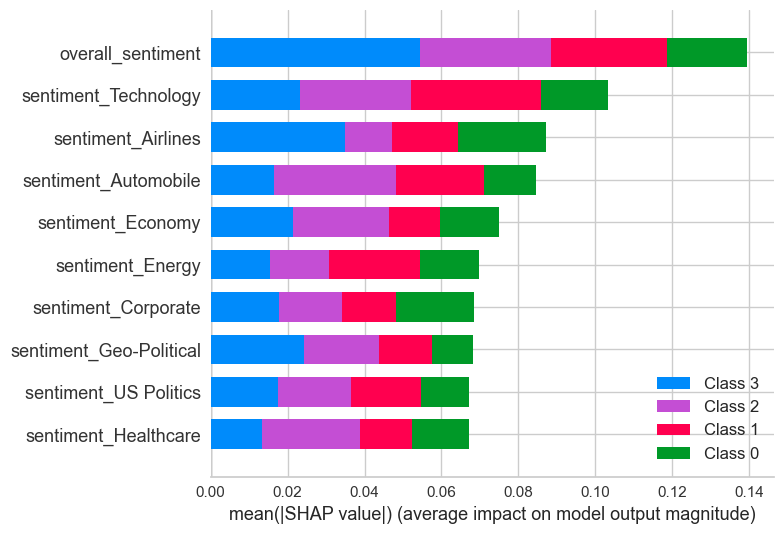

In [28]:
# SHAP feature importance for the finalized RandomForest model

# Use the same feature set the model is trained with
fs_name = "Sectoral sentiment"
fs_cols = feature_sets[fs_name]

X_train_fs = train_df[fs_cols].copy()
X_test_fs  = test_df[fs_cols].copy()

# best_cls is the finalized RandomForestClassifier from PyCaret
rf_model = best_cls

explainer = shap.TreeExplainer(rf_model)

shap_values = explainer.shap_values(X_test_fs)

plt.figure()
shap.summary_plot(shap_values, X_test_fs, show=False)
plt.tight_layout()
plt.show()

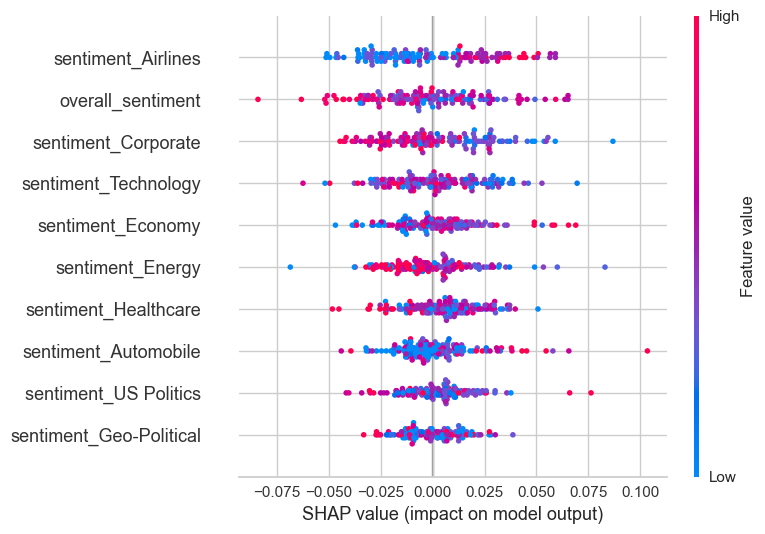

In [29]:
shap.summary_plot(shap_values[0], X_test_fs)

## MLFlow

In [30]:
# Set where to store mlruns
mlflow.set_tracking_uri("file:./mlruns")

# Group runs under a named experiment
mlflow.set_experiment("sp500_news_rf")


<Experiment: artifact_location='file:///Users/ankitagrawal/Desktop/mlops_project/market-movement-forecast/mlruns/434630062342215261', creation_time=1765393935797, experiment_id='434630062342215261', last_update_time=1765393935797, lifecycle_stage='active', name='sp500_news_rf', tags={}>

In [33]:
feature_cols = feature_cols_sector
target_col = "return_bucket"

X = df[feature_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

feature_order = list(X_train.columns)

with mlflow.start_run(run_name="rf_baseline"):

    # --- Define and train model ---
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
    )

    rf.fit(X_train, y_train)

    # --- Evaluate ---
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)  # for AUC

    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_weighted = f1_score(y_test, y_pred, average="weighted")

    # For multi-class AUC (works if >2 classes)
    try:
        auc_ovr = roc_auc_score(y_test, y_proba, multi_class="ovr")
    except ValueError:
        # e.g. if only 1 class present in y_test in this split
        auc_ovr = None

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 (macro): {f1_macro:.4f}")
    print(f"F1 (weighted): {f1_weighted:.4f}")
    if auc_ovr is not None:
        print(f"AUC (OvR): {auc_ovr:.4f}")
    else:
        print("AUC (OvR): not defined for this split")

    # --- Log parameters ---
    mlflow.log_param("model_type", "RandomForestClassifier")
    mlflow.log_param("n_estimators", rf.n_estimators)
    mlflow.log_param("max_depth", rf.max_depth)
    mlflow.log_param("n_features", len(feature_order))
    mlflow.log_param("target_col", target_col)

    # --- Log global metrics ---
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_macro", f1_macro)
    mlflow.log_metric("f1_weighted", f1_weighted)
    if auc_ovr is not None:
        mlflow.log_metric("auc_ovr", auc_ovr)

    # --- Class-wise precision / recall / F1 ---
    # Use labels in the same order as the model's classes_
    labels = rf.classes_
    prec, rec, f1_cls, support = precision_recall_fscore_support(
        y_test, y_pred, average=None, labels=labels
    )

    for cls, p, r, f1_c, sup in zip(labels, prec, rec, f1_cls, support):
        cls_str = str(cls)
        mlflow.log_metric(f"precision_class_{cls_str}", p)
        mlflow.log_metric(f"recall_class_{cls_str}", r)
        mlflow.log_metric(f"f1_class_{cls_str}", f1_c)
        mlflow.log_metric(f"support_class_{cls_str}", int(sup))

    # (Optional) log full text classification report as an artifact
    report = classification_report(y_test, y_pred, target_names=[str(c) for c in labels])
    with tempfile.TemporaryDirectory() as tmpdir:
        report_path = os.path.join(tmpdir, "classification_report.txt")
        with open(report_path, "w") as f:
            f.write(report)
        mlflow.log_artifact(report_path, artifact_path="reports")

    # --- Log feature order as an artifact ---
    with tempfile.TemporaryDirectory() as tmpdir:
        feature_path = os.path.join(tmpdir, "feature_order.json")
        with open(feature_path, "w") as f:
            json.dump(feature_order, f)
        mlflow.log_artifact(feature_path, artifact_path="preprocessing")

    # --- Log the model ---
    mlflow.sklearn.log_model(
        sk_model=rf,
        artifact_path="model",
    )

    run_id = mlflow.active_run().info.run_id

print("Run ID:", run_id)


2025/12/10 14:37:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Accuracy: 0.3525
F1 (macro): 0.3464
F1 (weighted): 0.3511
AUC (OvR): 0.6130


2025/12/10 14:37:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run ID: 4c6740cecc2c42e4a69736798a47a257


### Model Serving

In [ ]:
# In terminal
# mlflow models serve -m "runs:/4c6740cecc2c42e4a69736798a47a257/model" -p 5001 --no-conda


### Model Monitoring

In [86]:
from evidently import Report, Dataset, DataDefinition, MulticlassClassification
from evidently.presets import DataDriftPreset, ClassificationPreset


def generate_evidently_report(reference_df, current_df, name: str = "classification_monitoring"):
    """
    Generate an Evidently report for classification + data drift.

    Both reference_df and current_df must have:
      - 'target' column (true labels)
      - 'prediction' column (model predictions)
    """

    # 1) Tell Evidently which columns are target and prediction
    data_def = DataDefinition(
        classification=[
            MulticlassClassification(
                target="target",          # name of the true-label column
                prediction_labels="prediction",  # name of the predicted-label column
                # prediction_probas=None  # optional: list of prob columns if you have them
            )
        ]
    )

    # 2) Wrap Pandas DataFrames into Evidently Dataset objects
    ref_ds = Dataset.from_pandas(reference_df, data_definition=data_def)
    cur_ds = Dataset.from_pandas(current_df, data_definition=data_def)

    # 3) Build the report (no args to ClassificationPreset in 0.7.x)
    report = Report([
        ClassificationPreset(),
        DataDriftPreset(),
    ])

    # 4) Run the report: (current_data, reference_data)
    result = report.run(cur_ds, ref_ds)

    # 5) Save HTML
    html_path = f"{name}.html"
    result.save_html(html_path)
    print(f"Evidently report saved to: {html_path}")

    return result


In [96]:
import json
import numpy as np
import requests

X_new = X_test[feature_cols_sector].copy()

X_new = X_new.astype(float)

dataframe_split = {
    "columns": list(X_new.columns),
    "index": X_new.index.tolist(),
    "data": X_new.values.tolist(),
}

payload = {"dataframe_split": dataframe_split}

url = "http://127.0.0.1:5001/invocations"
headers = {"Content-Type": "application/json"}

response = requests.post(url, headers=headers, data=json.dumps(payload))

print("Status:", response.status_code)
print("Raw response text:", response.text)

if response.status_code != 200:
    raise RuntimeError("Serving failed")

data = response.json()
if isinstance(data, dict) and "predictions" in data:
    y_pred = data["predictions"]
else:
    y_pred = data


X_new['target'] = y_test.values
X_new['prediction'] = y_pred

Status: 200
Raw response text: {"predictions": ["up", "slightly_up", "slightly_down", "slightly_down", "slightly_up", "down", "up", "slightly_up", "slightly_up", "slightly_up", "slightly_up", "up", "up", "slightly_up", "down", "slightly_up", "slightly_up", "up", "slightly_up", "slightly_up", "down", "down", "slightly_down", "down", "slightly_down", "slightly_up", "up", "slightly_down", "slightly_up", "slightly_up", "down", "up", "slightly_down", "up", "up", "slightly_up", "up", "up", "slightly_up", "slightly_up", "up", "up", "slightly_up", "down", "up", "slightly_up", "up", "slightly_up", "down", "slightly_down", "up", "up", "up", "slightly_down", "slightly_up", "down", "slightly_up", "down", "slightly_up", "slightly_down", "up", "slightly_up", "up", "down", "down", "up", "down", "down", "slightly_up", "down", "down", "slightly_up", "down", "slightly_up", "up", "up", "slightly_down", "down", "down", "up", "down", "up", "slightly_down", "down", "slightly_down", "slightly_up", "up", "sli

In [102]:
import json
import numpy as np
import requests

X_changed = X_test[feature_cols_sector].copy()

X_changed = X_changed.astype(float)

X_changed['overall_sentiment'] = X_changed['overall_sentiment'] / 2
X_changed['sentiment_Airlines'] = X_changed['overall_sentiment'] * 2

dataframe_split = {
    "columns": list(X_changed.columns),
    "index": X_changed.index.tolist(),
    "data": X_changed.values.tolist(),
}

payload = {"dataframe_split": dataframe_split}

url = "http://127.0.0.1:5001/invocations"
headers = {"Content-Type": "application/json"}

response = requests.post(url, headers=headers, data=json.dumps(payload))

print("Status:", response.status_code)
print("Raw response text:", response.text)

if response.status_code != 200:
    raise RuntimeError("Serving failed")

data = response.json()
if isinstance(data, dict) and "predictions" in data:
    y_pred = data["predictions"]
else:
    y_pred = data


X_changed['target'] = y_test.values
X_changed['prediction'] = y_pred

Status: 200
Raw response text: {"predictions": ["up", "slightly_up", "slightly_up", "slightly_down", "slightly_up", "up", "up", "slightly_up", "up", "up", "up", "up", "up", "slightly_up", "down", "slightly_up", "slightly_up", "down", "slightly_up", "slightly_up", "slightly_up", "up", "slightly_down", "slightly_down", "up", "down", "up", "slightly_down", "slightly_up", "slightly_up", "down", "slightly_up", "slightly_down", "up", "up", "slightly_up", "up", "up", "slightly_up", "slightly_up", "up", "up", "slightly_up", "down", "up", "slightly_up", "up", "up", "down", "slightly_down", "up", "up", "up", "slightly_up", "slightly_down", "down", "slightly_up", "up", "slightly_down", "slightly_down", "up", "slightly_up", "up", "down", "down", "down", "down", "up", "slightly_down", "slightly_down", "up", "slightly_up", "down", "slightly_up", "slightly_up", "up", "down", "slightly_up", "up", "up", "down", "slightly_down", "slightly_down", "down", "slightly_down", "slightly_up", "up", "slightly_do

In [ ]:
report = generate_evidently_report(X_new, X_changed, name="sp500_monitoring")


Evidently report saved to: sp500_monitoring.html
